In [1]:
from __future__ import division
import numpy as np
import scipy as sc
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location
import pvlib.irradiance as irrad
from sklearn.neural_network import MLPRegressor 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import math
from sklearn.metrics import mean_squared_error
from random import gauss
from datetime import datetime
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib
from sklearn import linear_model
import cvxpy as cvp
import pickle
import json
import pdb
import os, warnings

# convert function notebook to script
!jupyter nbconvert --to script PV_forecast_function_notebook.ipynb
import PV_forecast_function_notebook as forfun

[NbConvertApp] Converting notebook PV_forecast_function_notebook.ipynb to script
[NbConvertApp] Writing 117348 bytes to PV_forecast_function_notebook.py


# Example Script

In [2]:
# Initialize models
models = {}
# Regression (for first time step(s))
models['regression'] = {}
models['regression']['loaded'] = True
models['regression']['history'] = 4
models['regression']['prediction'] = 2

# SARIMA
models['sarima'] = {}
models['sarima']['loaded'] = True
# models['sarima']['path'] = 'SARIMA_model_multiple_steps_20180926.json'
models['sarima']['path'] = os.getcwd()+'/models/all/20181031/SARIMA_model_20181025.json'
models['sarima']['model'] = {}
with open(models['sarima']['path'], 'rb') as f:
    SARIMAres = json.load(f)
models['sarima']['model']['SARIMAorder'] = np.array(SARIMAres['order'])
models['sarima']['model']['SARIMAparams'] = np.array(SARIMAres['params'])
models['sarima']['normPowerCoeff'] = float(2626.1504040404043)

# NN
models['nn'] = {}
models['nn']['loaded'] = True

# models['nn']['path'] = 'NNmodel_scalar_arch_T_T_T_T_T.sav'
# models['nn']['path'] = 'NNmodel_scalar_arch_F_T_T_F_F.sav'
# models['nn']['path'] = 'NNmodel_scalar_arch_F_T_T_F_F_20181024.sav'
# models['nn']['path'] = 'NNmodel_scalar_arch_T_T_T_F_F_20181024.sav'
# models['nn']['path'] = 'NNmodel_scalar_arch_T_T_T_T_T_20181024.sav'
# models['nn']['path'] = 'NNmodel_vector_arch_T_T_T_F_F.sav'
# models['nn']['path'] = os.getcwd()+'\models\NN\\20181025\NNmodel_scalar_arch_T_T_T_T_T.sav'
models['nn']['path'] = os.getcwd()+'/models/all/20181031/NNmodel_best_20181025.sav'

models['nn']['model'] = joblib.load(models['nn']['path'])

models['nn']['architecture'] = 'scalar'
# models['nn']['architecture'] = 'vector'

#                           ambient temp   cloud cover   clear sky    Pdminus1      predHorizon
models['nn']['inputData'] = [True,        True,         True,        True,        True]
# models['nn']['inputData'] = [False,        True,         True,        False,        False]
# models['nn']['inputData'] = [True,        True,         True,        False,        False]
models['nn']['randomSeed'] = 10 # if no randomSeed is used, set it to np.nan
models['nn']['normInputData'] = True
models['nn']['normPowerCoeff'] = float(2626.1504040404043)
models['nn']['normTa'] = float(30)
models['nn']['normCC'] = float(100)
models['nn']['normCS'] = float(1000)

# Alpha
models['alpha'] = {}
models['alpha']['loaded'] = True
# models['alpha']['path'] = 'optimal_weighting_factors_20181019.json'
models['alpha']['path'] = os.getcwd()+'/models/all/20181031/optimal_weighting_factors_20181031.json'
with open(models['alpha']['path'], 'rb') as f:
    alphaRes = json.load(f)
models['alpha']['model'] = np.array(alphaRes['alpha'])

models

{'alpha': {'loaded': True, 'model': array([[0.8979638 ],
         [0.83013131],
         [0.79342952],
         [0.73473742],
         [0.75010177],
         [0.70434345],
         [0.62377636],
         [0.61286919],
         [0.61544572],
         [0.56125668],
         [0.48285656],
         [0.48165696],
         [0.51837113],
         [0.4640004 ],
         [0.4651227 ],
         [0.47699954],
         [0.50674632],
         [0.45543317],
         [0.42733011],
         [0.4264174 ],
         [0.45596935],
         [0.42433813],
         [0.42488663],
         [0.47104167],
         [0.52367305],
         [0.48135456],
         [0.43566588],
         [0.44647714],
         [0.50573342],
         [0.43657695],
         [0.37756712],
         [0.38274822],
         [0.42931681],
         [0.38620124],
         [0.35606456],
         [0.40227649],
         [0.46092998],
         [0.42431682],
         [0.40185116],
         [0.43756444],
         [0.50329911],
         [0.46367739],


# Example how to get forecast

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


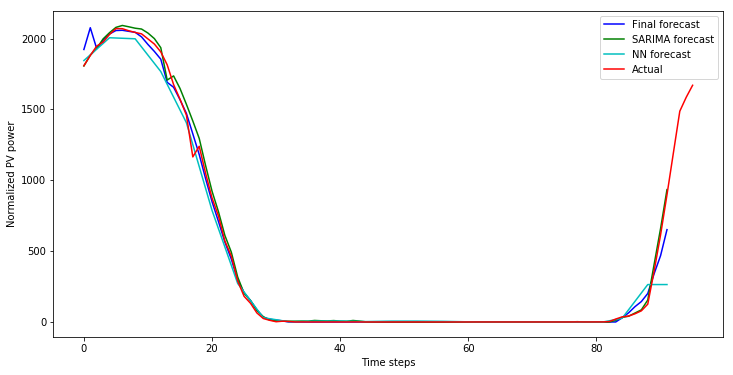

ValueError: cannot reshape array of size 96 into shape (92,1)

In [6]:
# Example how to get forecast
pv_data_file = '/home/christoph/Documents/SmartInverter/smartinverter_optimization/ExampleData/PV_data_20181024.csv'
df_pv, pv_df_1h = forfun.load_pv_data(pv_data_file)
filename = 'weather_forecast_dataframe_20181024.json'
wf_df = pd.read_json(filename)
wf_df.index = pd.to_datetime(wf_df.index)
wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold

monthIdx = 10
dayIdx = 15
hourIdx = 10
minuteIdx = 0

obsDf = df_pv.loc[df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,minuteIdx,0)]
wf_df = wf_df.loc[wf_df.index>=datetime(2018,monthIdx,dayIdx,hourIdx,minuteIdx,0)]

predHor = 96
timeStep = 15
timeStepCtrl = 20
tsPeriod = 96
retrainFlag = False
resample2CtrlStep = False
wfDf = wf_df.iloc[0]
wfDf['valid'] = True

PVforecast5min,PVforecast15min,PVforecastSARIMA,PVforecastNN = forfun.getPVforecast_v4(obsDf,wfDf,models,predHor,
                                                                                         timeStep,timeStepCtrl,
                                                                                         tsPeriod,retrainFlag,resample2CtrlStep)
#print('PV forecast from SARIMA model: {}'.format(PVforecastSARIMA.transpose()))
#print('PV forecast from NN model: {}'.format(PVforecastNN.transpose()))
#print('Final PV forecast: {}'.format(PVforecast.transpose()))

PVactual = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx,hourIdx,minuteIdx,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx+1,hourIdx,minuteIdx,0))]
PVactual_prevday = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx-1,hourIdx,minuteIdx,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,minuteIdx,0))]
plt.plot(PVforecast15min,'-b',label='Final forecast')
plt.plot(PVforecastSARIMA,'-g',label='SARIMA forecast')
plt.plot(PVforecastNN,'-c',label='NN forecast')
plt.plot(PVactual.tolist(),'-r',label='Actual')
#plt.plot(PVactual_prevday.tolist(),'-m',label='Actual day d-1')
plt.xlabel('Time steps')
plt.ylabel('Normalized PV power')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

prev_day = np.array(PVactual_prevday.tolist())
prev_day.shape=(PVforecastSARIMA.shape[0],1)
plt.plot(PVforecastSARIMA-prev_day,label='diff between SARIMA and d-1 persistence')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

plt.plot(models['alpha']['model'])
plt.xlabel('Time step in prediction horizon')
plt.ylabel('Weighting factor')
plt.show()

In [4]:
print throwerror

NameError: name 'throwerror' is not defined

In [ ]:
# get forecasts for a random set of cases to visually check results
warnings.filterwarnings("ignore")

pv_data_file = 'C:\Users\evvre\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\ExampleData\PV_data_20181024.csv'
df_pv, pv_df_1h = forfun.load_pv_data(pv_data_file)
filename = 'weather_forecast_dataframe_20181024.json'
wf_df = pd.read_json(filename)
wf_df.index = pd.to_datetime(wf_df.index)
wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold

# modelSaved = [os.getcwd()+'\models\NN\\20181025\\'+'NNmodel_scalar_arch_T_T_T_T_T.sav',
#               os.getcwd()+'\models\NN\\20181025\\'+'NNmodel_vector_arch_T_T_T_F_F.sav']
modelSaved = [os.getcwd()+'\models\NN\\20181025\\'+'NNmodel_scalar_arch_T_T_T_T_T.sav',
              os.getcwd()+'\models\NN\\20181025\\'+'NNmodel_vector_arch_T_T_T_F_F.sav']
NNarch = ['scalar','vector']
modelInput = [[True,True,True,True,True],[True,True,True,False,False]]

i=1
while i<=40:
    monthIdx = int(np.random.uniform(9,10,1))
    dayIdx = int(np.random.uniform(2,30,1))
    hourIdx = int(np.random.uniform(0,24,1))
    
    PVactual = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx+1,hourIdx,0,0))]
    PVactual_prevday = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx-1,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0))]
    
    if (len(PVactual)!=96) | (len(PVactual_prevday)!=96): continue
    
    obsDf = df_pv.loc[df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0)]
    wf_df_cur = wf_df.loc[wf_df.index>=datetime(2018,monthIdx,dayIdx,hourIdx,0,0)]

    predHor = 96
    timeStep = 15
    timeStepCtrl = 5
    tsPeriod = 96
    retrainFlag = False
    resample2CtrlStep = False
    wfDf = wf_df_cur.iloc[0]
    
    for j in range(len(modelSaved)):
        models['nn']['path'] = modelSaved[j]
        models['nn']['model'] = joblib.load(models['nn']['path'])
        models['nn']['architecture'] = NNarch[j]
        models['nn']['inputData'] = modelInput[j]
        PVforecast5min,PVforecast15min,PVforecastSARIMA,PVforecastNN = forfun.getPVforecast_v3(obsDf,wfDf,models,predHor,
                                                                                                 timeStep,timeStepCtrl,
                                                                                                 tsPeriod,retrainFlag,resample2CtrlStep)

        if j==0:            
            #plt.plot(PVforecast15min,'-b',label='Final forecast')
            #plt.plot(PVforecastSARIMA,'-g',label='SARIMA forecast')
            plt.plot(PVforecastNN,'-b',label='NN forecast SCALAR')
            plt.plot(PVactual.tolist(),'-r',label='Actual')
            #plt.plot(PVactual_prevday.tolist(),'-m',label='Actual day d-1')
            plt.xlabel('Time steps')
            plt.ylabel('PV power')
            plt.legend()
            fig = plt.gcf()
            fig.set_size_inches(8,4)
            tmp = PVforecastNN
            tmp.shape=(1,len(tmp))
            RMSEscalar = np.round(forfun.rmse(tmp,np.array(PVactual)),1)
        if j==1:
            plt.plot(PVforecastNN,'-g',label='NN forecast VECTOR')
            plt.legend()
            tmp = PVforecastNN
            tmp.shape=(1,len(tmp))
            RMSEvector = np.round(forfun.rmse(tmp,np.array(PVactual)),1)
            plt.title(str(datetime(2018,monthIdx,dayIdx,hourIdx,0,0))+' RMSE scalar: '+str(RMSEscalar)+' RMSE vector: '+str(RMSEvector))
            plt.show()
    i+=1

In [ ]:
# get forecasts for a period of time
pv_data_file = 'PV_data_20181024.csv'
df_pv, pv_df_1h = forfun.load_pv_data(pv_data_file)
filename = 'weather_forecast_dataframe_20181024.json'
wf_df = pd.read_json(filename)
wf_df.index = pd.to_datetime(wf_df.index)
wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold

# models['nn']['path'] = 'NNmodel_scalar_arch_T_T_T_T_T.sav'
# models['nn']['model'] = joblib.load(models['nn']['path'])
# models['nn']['architecture'] = 'scalar'
# models['nn']['inputData'] = [True,True,True,True,True]

predHor = 96
timeStep = 15
timeStepCtrl = 5
tsPeriod = 96
retrainFlag = False
resample2CtrlStep = False

PVforecastSARIMA_list = []
PVforecastNN_list = []
PVactual_list = []
PVactual_prevday_list = []
PVforecastFinal_list = []
forecastStamp_list = []
forecastHour_list = []
RMSE_SARIMA_list = []
RMSE_NN_list = []
RMSE_Final_list = []

curStamp = datetime(2018,9,1,0,0,0)

while curStamp<datetime(2018,9,15,0,0,0):
    print('Timestep: {}'.format(curStamp))
    PVactual = df_pv.loc[(df_pv.index>=curStamp) & (df_pv.index<curStamp+pd.Timedelta(days=1))]
    PVactual_prevday = df_pv.loc[(df_pv.index>=curStamp-pd.Timedelta(days=1)) & (df_pv.index<curStamp)]
    
    
    if (len(PVactual)!=96) | (len(PVactual_prevday)!=96):
        curStamp = curStamp + pd.Timedelta(minutes=timeStep)
        continue
    
    obsDf = df_pv.loc[df_pv.index<curStamp]
    wf_df_cur = wf_df.loc[wf_df.index>=curStamp]
    wfDf = wf_df_cur.iloc[0]
    
    PVforecast5min,PVforecastFinal,PVforecastSARIMA,PVforecastNN = forfun.getPVforecast_v3(obsDf,wfDf,models,predHor,
                                                                                                 timeStep,timeStepCtrl,
                                                                                                 tsPeriod,retrainFlag,resample2CtrlStep)
    PVforecastSARIMA.shape=(1,len(PVforecastSARIMA))
    PVforecastNN.shape=(1,len(PVforecastNN))
    PVforecastFinal.shape=(1,len(PVforecastFinal))
    forecastStamp_list = forecastStamp_list + [curStamp]
    forecastHour_list = forecastHour_list + [curStamp.hour+curStamp.minute/60.0]
    PVforecastSARIMA_list = PVforecastSARIMA_list + [PVforecastSARIMA.tolist()[0]]
    PVforecastNN_list = PVforecastNN_list + [PVforecastNN.tolist()[0]]
    PVforecastFinal_list = PVforecastFinal_list + [PVforecastFinal.tolist()[0]]
    PVactual_list = PVactual_list + [PVactual.tolist()]
    PVactual_prevday_list = PVactual_prevday_list + [PVactual_prevday.tolist()]
    
    RMSE_SARIMA = np.round(forfun.rmse(PVforecastSARIMA,np.array(PVactual)),1)
    RMSE_NN = np.round(forfun.rmse(PVforecastNN,np.array(PVactual)),1)
    RMSE_Final = np.round(forfun.rmse(PVforecastFinal,np.array(PVactual)),1)
    RMSE_SARIMA_list = RMSE_SARIMA_list + [RMSE_SARIMA]
    RMSE_NN_list = RMSE_NN_list + [RMSE_NN]
    RMSE_Final_list = RMSE_Final_list + [RMSE_Final]
    print('RMSE SARIMA: {}   RMSE NN: {}   RMSE Final: {}'.format(RMSE_SARIMA,RMSE_NN,RMSE_Final))

    curStamp = curStamp + pd.Timedelta(minutes=timeStep)
    
dfAllRes = pd.DataFrame(data=np.array([forecastStamp_list,forecastHour_list,PVforecastSARIMA_list,PVforecastNN_list,
                                PVforecastFinal_list,PVactual_list,PVactual_prevday_list,
                                RMSE_SARIMA_list,RMSE_NN_list,RMSE_Final_list]).transpose(),
                  columns=['timestamp','hour_index','SARIMA_forecast','NN_forecast','Final_forecast',
                           'PV_power','PV_power_dminus1','RMSE_SARIMA','RMSE_NN','RMSE_final'],
                       index=np.array(forecastStamp_list))
dfAllRes.to_json('long_forecast_combined_20181029')

In [ ]:
allRes = dfAllRes
plt.bar(np.arange(0,len(allRes)),allRes['RMSE_SARIMA'],label='SARIMA')
plt.bar(np.arange(0,len(allRes)),allRes['RMSE_NN'],label='NN')
plt.bar(np.arange(0,len(allRes)),allRes['RMSE_final'],label='Final')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18,8)
plt.show()

print(np.mean(allRes['RMSE_SARIMA']))
print(np.mean(allRes['RMSE_NN']))
print(np.mean(allRes['RMSE_final']))

datestring = datetime(2018,9,4,0,0,0)

fs = 14
plt.plot(allRes['SARIMA_forecast'].loc[datestring],label='SARIMA forecast')
plt.plot(allRes['NN_forecast'].loc[datestring],label='NN forecast')
plt.plot(allRes['Final_forecast'].loc[datestring],label='Final forecast')
plt.plot(allRes['PV_power'].loc[datestring],label='Actual')
plt.legend(fontsize=fs)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.xlabel('Time steps',fontsize=fs)
plt.ylabel('Power (W)',fontsize=fs)
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

In [ ]:
# loop prediction
PVforecastSARIMA_1step = []
obsDf = train
for i in range(96):
    print(i)
    if i>0:
        obsDf = obsDf.append(pd.DataFrame(data=([test.iloc[i]]),index=[obsDf.index[-1] + pd.Timedelta(minutes=timeStep)]))
    tmp1, tmp2, tmp3 = getPVforecast(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,wfDf,alpha)
    PVforecastSARIMA_1step = PVforecastSARIMA_1step + tmp2[0].tolist()
    print(PVforecastSARIMA_1step)

In [ ]:
plt.plot(test.iloc[0:96].tolist(),'-b',label='Actual')
plt.plot(PVforecastSARIMA_1step,'-r',label='1-step-ahead forecast')
plt.plot(PVforecastSARIMA,'-g',label='Day-ahead forecast')
plt.title('PV power forecast using a SARIMA model',fontsize=15)
plt.xlabel('15-minute time steps',fontsize=15)
plt.ylabel('PV power (normalized)',fontsize=15)
plt.tick_params('x', labelsize=15)
plt.tick_params('y', labelsize=15)
plt.grid()
plt.legend(fontsize=15)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()


# Example on how to re-train models

In [ ]:
# Example to show how to retrain combined model
filenameSARIMAnew = 'SARIMA_model_example.json'
filenameNNnew = 'NNmodel_best_example.sav'
filenameAlphaNew = 'optimal_weighting_factors_example'
hyperParams={'hidden_layer_sizes': [(50,50),(75,75)],
                                      'activation': ['relu','tanh'],
                                      'solver': ['lbfgs'],'learning_rate': ['constant'],'max_iter': [10000],
                                      'validation_fraction': [0.25]}
df_train = df_pv.loc[df_pv.index>=datetime(2018,8,29,0,0,0)]
wf_train = wf_df.loc[wf_df.index>=datetime(2018,8,29,0,0,0)]

forfun.retrainCombinedModel(models,df_train,wf_train,filenameSARIMAnew,filenameNNnew,filenameAlphaNew,0.5,hyperParams,96,15,96)

In [ ]:
# Example on how to reoptimize weighting factors
pv_data_file = 'C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\ExampleData\PV_data.csv'
df_pv, pv_df_1h = forfun.load_pv_data(pv_data_file)
filename = 'weather_forecast_dataframe_20181015.json'
wf_df = pd.read_json(filename)
wf_df.index = pd.to_datetime(wf_df.index)
wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold

SARIMAorder = models['sarima']['model']['SARIMAorder']
SARIMAparams = models['sarima']['model']['SARIMAparams']
initPerc = 0.05 # use 5% of available data for SARIMA model initialization
initSize = int(initPerc*len(df_pv))
initSet, trainSet = df_pv.iloc[0:initSize], df_pv.iloc[initSize:len(df_pv)]
predHor=96
timeStep=15
tsPeriod=96
NNmodel = models['nn']['model']
normalizeData = models['nn']['normInputData']
normalizeFactorSARIMA = float(models['sarima']['normPowerCoeff'])
normalizeFactorNN = float(models['nn']['normPowerCoeff'])
filename = 'optimal_weighting_factors_20181019.json'

optimizeWeights(SARIMAorder,SARIMAparams,initSet,trainSet,predHor,timeStep,tsPeriod,
                NNmodel,normalizeData,normalizeFactorSARIMA,normalizeFactorNN,wf_df,filename)

In [ ]:
with open(filenameSARIMAnew, 'rb') as f:
    SARIMA_example = json.load(f)
SARIMAorder_example = np.array(SARIMA_example['order'])
SARIMAparams_example = np.array(SARIMA_example['params'])
print(SARIMA_example)

NN_example = joblib.load(filenameNNnew)
print(NN_example)

with open(filenameAlphaNew, 'rb') as f:
    alpha_example = json.load(f)
alpha_example = np.array(alpha_example['alpha'])
print(alpha_example.transpose())

# Recycle Bin

In [ ]:
a1 = [1,2,3]
a2 = [0,0,0]

a2 = a1

a2[0] = 3

print(a1)   # [3 2 3]
print(a2)   # [1 2 3]

In [ ]:
a=np.array([1,1])
b=np.array([3,3])
b=a
print(a,b)
b=np.array([2,2])
print(a,b)

In [ ]:
a=np.array([1,1])
b=np.array([3,3])
b=a
print(a,b)
b[0]=2
print(a,b)

In [ ]:
# Example to show how to retrain SARIMA model
filename1 = 'SARIMA_model_final.json'
filename2 = 'SARIMA_model_updated.json'
obsDf = df_pv

SARIMA_model_updated = retrainSARIMAmodel(obsDf,filename1,filename2)


In [ ]:
# Train SARIMA without fixed order from previous training
filename = 'SARIMA_model_'+str(int(time.time()))+'.json'
startTime = time.time()

# train = df_pv
train = df_pv.loc[(df_pv.index>=datetime(2018,9,19))]

SARIMAorder = np.array([2, 0, 0, 0, 1, 1])
model = SARIMAX(train, order=(SARIMAorder[0], SARIMAorder[1], SARIMAorder[2]), 
                seasonal_order=(SARIMAorder[3], SARIMAorder[4], SARIMAorder[5], tsPeriod))#,enforce_stationarity=False)#,enforce_invertibility=False)
model_fit = model.fit(disp=1, method='lbfgs', maxiter=100)
SARIMAparams = model_fit.params
print('The new params are: {}'.format(SARIMAparams))

SARIMA_model_updated = {'order':SARIMAorder.tolist(), 'params':SARIMAparams.get_values().tolist()}
with open(filename, 'wb') as f:
    json.dump(SARIMA_model_updated, f)
    
optTime = time.time() - startTime
print('Total time (s): {}'.format(optTime))

In [ ]:
# Example of retraining SARIMA with fixed order structure
filename = 'SARIMA_model_'+str(int(time.time()))+'.json'

startTime = time.time()

with open('SARIMA_model_updated_with_normalization.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order']) # fix the already identified optimal order structure
SARIMA_params_old = np.array(SARIMAres['params'])
print('The old params are: {}'.format(SARIMA_params_old))

train = df_pv
# train = df_pv.loc[(df_pv.index>=datetime.datetime(2018,8,26))]

model = SARIMAX(train, order=(SARIMAorder[0], SARIMAorder[1], SARIMAorder[2]), 
                seasonal_order=(SARIMAorder[3], SARIMAorder[4], SARIMAorder[5], tsPeriod))#,enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit(disp=1, method='lbfgs',start_params=SARIMA_params_old)
SARIMAparams = model_fit.params
print('The new params are: {}'.format(SARIMAparams))

SARIMA_model_updated = {'order':SARIMAorder.tolist(), 'params':SARIMAparams.get_values().tolist()}
with open(filename, 'wb') as f:
    json.dump(SARIMA_model_updated, f)
    
optTime = time.time() - startTime
print('Total time (s): {}'.format(optTime))

In [ ]:
with open('SARIMA_model_20180921.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order'])
SARIMAparams = np.array(SARIMAres['params'])
print(SARIMAparams)
with open('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\Forecasting\old\data_and_results\second_tuning_version\SARIMA_model_updated_with_normalization.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order'])
SARIMAparams = np.array(SARIMAres['params'])
print(SARIMAparams)


In [ ]:
## loop prediction
#PVforecastSARIMA_1step = []
#for i in range(96):
#    print(i)
#    obsDf = obsDf.append(test.iloc[0:i])
#    tmp1, tmp2, tmp3 = getPVforecast(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,wfDf,alpha)
#    PVforecastSARIMA_1step = PVforecastSARIMA_1step.append(tmp2[0])
#    print(PVforecastSARIMA_1step)
#

In [ ]:
# plt.plot(PVforecastSARIMA,'-b',label='forecast')
# plt.plot(PVforecastNN,'-g',label='forecast')
# plt.plot(test.iloc[0:96].tolist(),'-r',label='actual')

plt.plot(PVforecast,'-b',label='forecast')
plt.plot(np.repeat(test.iloc[0:96].tolist(),3),'-r',label='actual')

plt.legend()
plt.show()

In [ ]:
model_fit.summary()

fig, ax = plt.subplots()
plt.plot(train,label='actual')
plt.plot(model_fit.fittedvalues,'-r',label='forecast')
plt.title('1-step ahead forecast')
plt.ylabel('Normalized PV power')
plt.legend()
fig.set_size_inches(15,5)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
resSTD = np.std(residuals.values)
resMEAN = np.mean(residuals.values)

In [ ]:
## Just to create an example obsDf dataframe series
## Load cleaned-up PV data
## df_pv = pd.read_pickle('PV_data_cleanedup')
#df_pv = pd.read_csv('PV_data_cleanedup.csv',index_col=[0])
#
## Further remove bad data by visual inspection
#dayIdxOut = []
#bad_days = [5, 29, 30]
#bad_ilocs = [288*(bd-1) for bd in bad_days]
#for bi in bad_ilocs:
#    dayIdxOut.append(df_pv['DayIndex'].iloc[bi])
#
#for i in range(len(dayIdxOut)):
#    df_pv = df_pv.loc[(df_pv['DayIndex']!=dayIdxOut[i])]
#
## Set index
#df_pv['date'] = pd.to_datetime(df_pv['date'])
#df_pv = df_pv.set_index('date')
#    
## Keep only data for April/May, because they are continuous
#i = 0
#while (df_pv.index[i].month<3) | (df_pv.index[i].month>6): 
#    i+=1
#df_pv = df_pv.iloc[i:]

useNewData = True

if (useNewData==False):
    # SECOND ROUND OF DATA 
    df_pv = pd.read_csv('PV_data_cleanedup_20180904.csv',index_col=[0])
    # Set index
    df_pv['date'] = pd.to_datetime(df_pv['date'])
    df_pv = df_pv.set_index('date')

    # Normalize data
    # df_pv = df_pv['totPower'] # use this if total PV power is of interest
    df_pv = df_pv['PV1_activePower_computed'] # use this if only inverter 1 PV power is of interest
    normalizeData = False
    if normalizeData:
        df_pv_nom = np.amax(df_pv)
        df_pv = df_pv/np.abs(df_pv_nom)

    # if 5min time step is used, seasonal period is 288 steps (1 day)
    # tsPeriod = 288 
    df_pv = df_pv.resample('15T').mean()
    # df_pv = df_pv.dropna()
    tsPeriod = 96
else:
    # Load data collected in September
    df_pv = pd.read_csv('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\ExampleData\PV_data.csv',index_col=[0])
    df_pv.index = pd.to_datetime(df_pv.index)
    df_pv = df_pv.resample('15T').mean()
    # df_pv = df_pv.dropna()
    tsPeriod = 96
    df_pv = df_pv['DC_PV_W']
    normalizeData = False
    if normalizeData:
        df_pv_nom = np.amax(df_pv)
        df_pv = df_pv/np.abs(df_pv_nom)
    # print(df_pv)
    #df_pv = df_pv.dropna()
    plt.plot(df_pv.iloc[0:96*4*2].tolist())
    plt.show()
    
# Weather data
# wf_df = pd.read_pickle('weather_forecast_dataframe')
wf_df = pd.read_json('weather_forecast_dataframe_updated.json')
wf_df.index = pd.to_datetime(wf_df.index)
wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold

In [ ]:
# Example how to get forecast
#print(wf_df.index[0])
#print(df_pv.index[0])

monthIdx = 9
dayIdx = 12
hourIdx = 14

obsDf = df_pv.loc[df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0)]
wf_df = wf_df.loc[wf_df.index>=datetime(2018,8,dayIdx,hourIdx,0,0)]

#data = np.load('SARIMA_best_models_15_min.npz')
#SARIMAorder = data['listOfOrders'][0]
#print(SARIMAorder)
#SARIMAparams = data['listOfParams'][0]

# SARIMAres = np.load('SARIMA_model_final_v2.npz')
# SARIMAorder = SARIMAres['order']
# SARIMAparams = SARIMAres['params']

# with open('SARIMA_model_20180921.json', 'rb') as f:
# with open('C:\Users\Vaggelis Vrettos\Dropbox\LBNL Research Scientist\CEC smart inverter\smartinverter_optimization\Forecasting\old\data_and_results\second_tuning_version\SARIMA_model_updated_with_normalization.json', 'rb') as f:
with open('SARIMA_model_multiple_steps_20180926.json', 'rb') as f:
    SARIMAres = json.load(f)
SARIMAorder = np.array(SARIMAres['order'])
SARIMAparams = np.array(SARIMAres['params'])

# modelsAll = pickle.load(open('NNmodel_updated.sav', 'rb'))
#modelsAll = joblib.load('NNmodel_20180921.sav')
#NNmodel = modelsAll.best_estimator_
NNmodel = joblib.load('NNmodel_best_20180927_normalize_input_outofsample.sav')
predHor = 96
timeStep = 15
timeStepCtrl = 5
tsPeriod = 96
retrainFlag = False
resample2CtrlStep = False
wfDf = wf_df.iloc[0]
# alpha = np.ones(96) 
#with open('optimal_weighting_factors_updated.json') as f:
with open('optimal_weighting_factors_20180921.json') as f:
    tmp = json.load(f)
alpha = 0*np.array(tmp['alpha'])
    
normalizeData = True
PVforecast5min, PVforecast15min, PVforecastSARIMA, PVforecastNN = getPVforecast_v1(obsDf,SARIMAorder,SARIMAparams,predHor,timeStep,timeStepCtrl,tsPeriod,retrainFlag,NNmodel,normalizeData,wfDf,alpha,resample2CtrlStep)
#print('PV forecast from SARIMA model: {}'.format(PVforecastSARIMA.transpose()))
#print('PV forecast from NN model: {}'.format(PVforecastNN.transpose()))
#print('Final PV forecast: {}'.format(PVforecast.transpose()))

PVactual = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx+1,hourIdx,0,0))]
PVactual_prevday = df_pv.loc[(df_pv.index>=datetime(2018,monthIdx,dayIdx-1,hourIdx,0,0)) & (df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,0,0))]
plt.plot(PVforecast15min,'-b',label='Final forecast')
plt.plot(PVforecastSARIMA,'-g',label='SARIMA forecast')
plt.plot(PVforecastNN,'-c',label='NN forecast')
plt.plot(PVactual.tolist(),'-r',label='Actual')
plt.plot(PVactual_prevday.tolist(),'-m',label='Actual day d-1')
plt.xlabel('Time steps')
plt.ylabel('Normalized PV power')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

prev_day = np.array(PVactual_prevday.tolist())
prev_day.shape=(PVforecastSARIMA.shape[0],1)
plt.plot(PVforecastSARIMA-prev_day,label='diff between SARIMA and d-1 persistence')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()


In [ ]:
# Alpha
models['alpha'] = {}
models['alpha']['loaded'] = True
models['alpha']['path'] = 'optimal_weighting_factors_MOSEK_1538179073.json'
with open(models['alpha']['path'], 'rb') as f:
    alphaRes = json.load(f)
models['alpha']['model'] = np.array(alphaRes['alpha'])

models['alpha2'] = {}
models['alpha2']['loaded'] = True
models['alpha2']['path'] = 'optimal_weighting_factors_ECOS_1538179073.json'
with open(models['alpha']['path'], 'rb') as f:
    alphaRes = json.load(f)
models['alpha2']['model'] = np.array(alphaRes['alpha'])

np.amax(models['alpha']['model']-models['alpha2']['model'])